<a href="https://colab.research.google.com/github/siddley1001/DataGlacier_CabG2M/blob/main/Cab_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import holidays

#Sklearn Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#Non SkLearn Regression Models
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#Sklearn Utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer #used to transform numerical and categorical features

GRAPH_PATH = '/content/drive/MyDrive/Data Glacier Internship Spring 2021/Pics/'
plt.style.use('seaborn')

In [ ]:
def fitscore(pipeline, X_train, y_train, X_test, y_test, cv):
    ''' Fit pipeline on Training data and return the mean RMSE of the cross_val_score from the test/validation data'''    
    pipeline.fit(X_train, y_train)
    return round(np.sqrt(-1* cross_val_score(pipeline, X_test, y_test, cv= cv, scoring = 'neg_mean_squared_error').mean()), 6)

In [ ]:
import warnings
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
        
    Code adapted from https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
    """

    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

def feature_weights(pipeline):
# Returns the Weights of the Features in a Linear Regression Pipeline
    arr = np.empty((0,2), float)
    for name, number in zip(get_feature_names(pipeline[0]), pipeline[1].coef_):
        arr = np.append(arr, np.array([[name, number]]), axis=0)

    importance_df = pd.DataFrame(arr, columns = ['Feature', 'Weight'])
    importance_df['Weight'] = importance_df['Weight'].astype('float')
    return importance_df.sort_values(by='Weight', ascending = False)

Detail all the URLs from the GitHub Repo

In [77]:
cab_data_url = 'https://raw.githubusercontent.com/siddley1001/DataSets/main/Cab_Data.csv'
city_url = "https://raw.githubusercontent.com/siddley1001/DataSets/main/City.csv"
customer_id_url = "https://raw.githubusercontent.com/siddley1001/DataSets/main/Customer_ID.csv"
transaction_id_url = "https://raw.githubusercontent.com/siddley1001/DataSets/main/Transaction_ID.csv"

In [78]:
cab_data = pd.read_csv(cab_data_url)
city_data = pd.read_csv(city_url)
customer_data = pd.read_csv(customer_id_url)
transaction_data = pd.read_csv(transaction_id_url)

# Merge Dataframes to Create a MASTER table.

In [79]:
customer_transactions = pd.merge(customer_data, transaction_data, on= 'Customer ID')
cab_city = pd.merge(cab_data, city_data, on = 'City')
master_df = pd.merge(cab_city, customer_transactions, on = 'Transaction ID')

pd.isnull(master_df).sum(axis =0)

Transaction ID        0
Date of Travel        0
Company               0
City                  0
KM Travelled          0
Price Charged         0
Cost of Trip          0
Population            0
Users                 0
Customer ID           0
Gender                0
Age                   0
Income (USD/Month)    0
Payment_Mode          0
dtype: int64

# Key Question: Predict Profit per Company

In [80]:
master_df.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users,Customer ID,Gender,Age,Income (USD/Month),Payment_Mode
0,10000011,1/8/2016,Pink Cab,ATLANTA GA,30.45,370.95,313.635,"814,885","24,701",29290,Male,28,10813,Card
1,10000012,1/6/2016,Pink Cab,ATLANTA GA,28.62,358.52,334.854,"814,885","24,701",27703,Male,27,9237,Card
2,10000013,1/2/2016,Pink Cab,ATLANTA GA,9.04,125.20,97.632,"814,885","24,701",28712,Male,53,11242,Cash
3,10000014,1/7/2016,Pink Cab,ATLANTA GA,33.17,377.40,351.602,"814,885","24,701",28020,Male,23,23327,Cash
4,10000015,1/3/2016,Pink Cab,ATLANTA GA,8.73,114.62,97.776,"814,885","24,701",27182,Male,33,8536,Card


In [81]:
print('There are {} cab rides (transactions) to analyze'.format(master_df.shape[0]))

There are 359392 cab rides (transactions) to analyze


In [82]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Transaction ID      359392 non-null  int64  
 1   Date of Travel      359392 non-null  object 
 2   Company             359392 non-null  object 
 3   City                359392 non-null  object 
 4   KM Travelled        359392 non-null  float64
 5   Price Charged       359392 non-null  float64
 6   Cost of Trip        359392 non-null  float64
 7   Population          359392 non-null  object 
 8   Users               359392 non-null  object 
 9   Customer ID         359392 non-null  int64  
 10  Gender              359392 non-null  object 
 11  Age                 359392 non-null  int64  
 12  Income (USD/Month)  359392 non-null  int64  
 13  Payment_Mode        359392 non-null  object 
dtypes: float64(3), int64(4), object(7)
memory usage: 41.1+ MB


In [83]:
master_df.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users,Customer ID,Gender,Age,Income (USD/Month),Payment_Mode
0,10000011,1/8/2016,Pink Cab,ATLANTA GA,30.45,370.95,313.635,"814,885","24,701",29290,Male,28,10813,Card
1,10000012,1/6/2016,Pink Cab,ATLANTA GA,28.62,358.52,334.854,"814,885","24,701",27703,Male,27,9237,Card
2,10000013,1/2/2016,Pink Cab,ATLANTA GA,9.04,125.20,97.632,"814,885","24,701",28712,Male,53,11242,Cash
3,10000014,1/7/2016,Pink Cab,ATLANTA GA,33.17,377.40,351.602,"814,885","24,701",28020,Male,23,23327,Cash
4,10000015,1/3/2016,Pink Cab,ATLANTA GA,8.73,114.62,97.776,"814,885","24,701",27182,Male,33,8536,Card


In [84]:
master_df.describe()

,Transaction ID,KM Travelled,Price Charged,Cost of Trip,Customer ID,Age,Income (USD/Month)
count,3.593920e+05,359392.000000,359392.000000,359392.000000,359392.000000,359392.000000,359392.000000
mean,1.022076e+07,22.567254,423.443311,286.190113,19191.652115,35.336705,15048.822937
std,1.268058e+05,12.233526,274.378911,157.993661,21012.412463,12.594234,7969.409482
min,1.000001e+07,1.900000,15.600000,19.000000,1.000000,18.000000,2000.000000
25%,1.011081e+07,12.000000,206.437500,151.200000,2705.000000,25.000000,8424.000000
50%,1.022104e+07,22.440000,386.360000,282.480000,7459.000000,33.000000,14685.000000
75%,1.033094e+07,32.960000,583.660000,413.683200,36078.000000,42.000000,21035.000000
max,1.044011e+07,48.000000,2048.030000,691.200000,60000.000000,65.000000,35000.000000


In [85]:
master_df['Date of Travel'].sort_values(ascending = True)
print('The data spans 3 Years from 2016 - 2018')

The data spans 3 Years from 2016 - 2018


## Column Transformations + Feature Generation
- Date
- Population
- Users


In [86]:
master_df['Date of Travel'] = pd.to_datetime(master_df['Date of Travel'], format= '%m/%d/%Y')

#Replace commas in the column
master_df.Population = master_df['Population'].str.replace(",", "")
master_df.Users = master_df['Users'].str.replace(',', "")

master_df.Population = master_df.Population.astype(int, copy = False)
master_df.Users = master_df.Users.astype(int, copy = False)

In [87]:
#Generate Target Feature
master_df['Profit'] = master_df['Price Charged'] - master_df['Cost of Trip']

#Save pre-feature engineered data for baseline models
usable_master = master_df.copy()
usable_master_pink = usable_master.loc[usable_master['Company'] == 'Pink Cab']
usable_master_yellow = usable_master.loc[usable_master['Company'] == 'Yellow Cab']

New Features

In [88]:
master_df['Customer_Gender_Male'] = master_df['Gender'].apply(lambda sex: 1 if sex == 'Male' else 0).astype(bool)
master_df.drop('Gender',axis = 1, inplace = True)

master_df['% of Population that are Users'] = master_df['Users']/master_df['Population']

In [89]:
unq_cities = master_df.City.unique().tolist()

timezones = ['EDT', 'CDT', 'EDT', 'CDT', 'CDT', 'MDT', 'PDT', 'EDT', 'CDT', 
             'EDT', 'PDT', 'MST', "EST", 'PDT', 'PDT', 'PDT', 'PDT', 'MST', 'EDT' ]

location_dict = {}

for city, tz in zip(unq_cities, timezones):
    location_dict[city] = tz

master_df['Timezone'] = master_df['City'].map(location_dict)

In [90]:
us_holidays = holidays.US()
master_df['on_holiday'] = master_df['Date of Travel'].apply(lambda date: True if date in us_holidays else False).astype(bool)

**Generate "Quarter"** feature from Datetime ('Date of Travel') column

In [91]:
master_df['Month'] = master_df['Date of Travel'].apply(lambda date: date.month)
master_df['Year'] = master_df['Date of Travel'].apply(lambda date: date.year)
master_df.drop('Date of Travel', axis = 1, inplace = True)

In [92]:
# quarter_map = {1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4}
# master_df['Quarter'] = master_df['Month'].map(quarter_map)

# Feature Visualization

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text major ticklabel objects>)

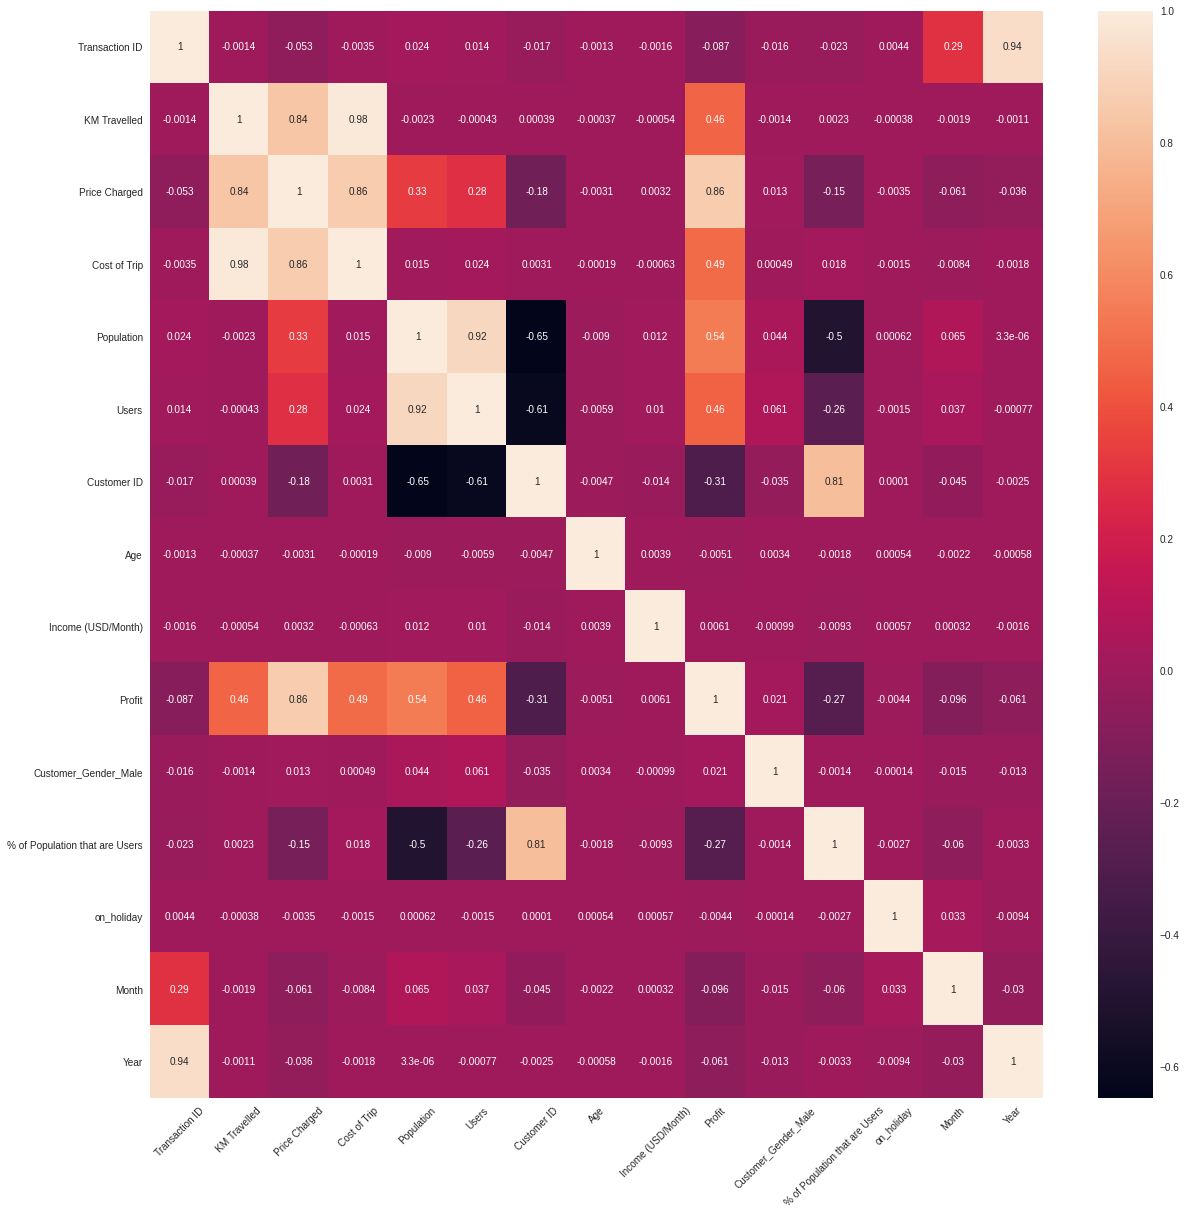

In [93]:
plt.figure(figsize = (20,20))
sns.heatmap(master_df.corr(), annot=True)
plt.xticks(rotation = 45)

<Figure size 288x288 with 0 Axes>

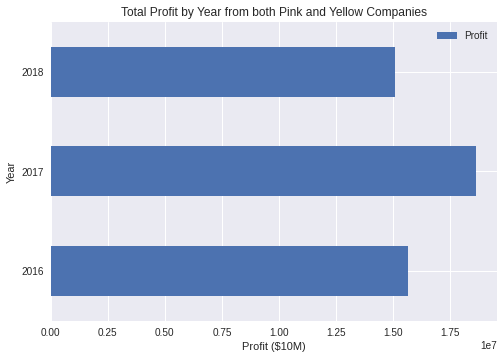

In [94]:
plt.figure(figsize = (4,4))
master_df.groupby('Year').agg({'Profit': 'sum'}).plot(kind = 'barh')
plt.title('Total Profit by Year from both Pink and Yellow Companies')
plt.xlabel('Profit ($10M)')
plt.savefig(GRAPH_PATH + 'Total Profit by Year.png', dpi=300, format='png')

In [95]:
master_df.groupby('Year').agg({'Profit': 'sum'}).pct_change()

,Profit
Year,
2016,NaN
2017,0.189836
2018,-0.189798


<Figure size 288x288 with 0 Axes>

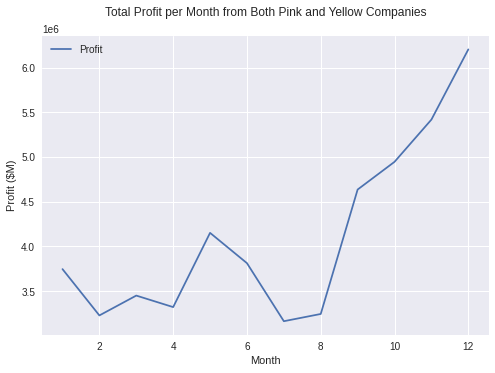

In [96]:
plt.figure(figsize = (4,4))
master_df.groupby('Month').agg({'Profit': 'sum'}).plot()
plt.title('Total Profit per Month from Both Pink and Yellow Companies', pad=20)
plt.ylabel('Profit ($M)')
plt.savefig(GRAPH_PATH + 'Total Profit by Month.png', dpi=300, format='png')

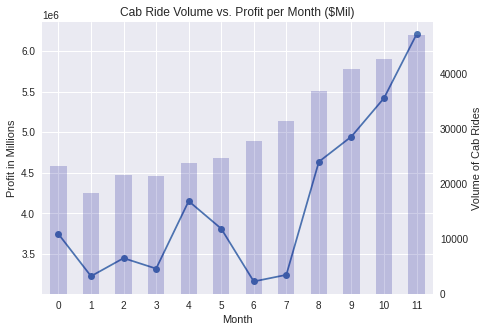

In [97]:
monthly_profit = master_df.groupby('Month').agg({'Profit': 'sum'})
monthly_transactions = master_df.groupby('Month').agg({'Transaction ID': 'count'})
monthly = pd.concat([monthly_profit, monthly_transactions], axis = 1)
monthly.index = monthly.index -1

fig, ax1 = plt.subplots(figsize = (7,5))
monthly['Profit'].plot(kind = 'line', marker = 'o', ax = ax1)
ax2 = ax1.twinx()  # set up the 2nd axis
monthly['Transaction ID'].plot(kind = 'bar', ax = ax2, alpha=0.2, color='darkblue')
ax2.grid(b = False)

plt.title('Cab Ride Volume vs. Profit per Month ($Mil)')
ax1.set_ylabel('Profit in Millions')
ax2.set_ylabel('Volume of Cab Rides')

plt.savefig(GRAPH_PATH + 'Volume vs. Profit by Month.png', dpi=300, format='png')

2017 was the best year profit-wise for Both companies


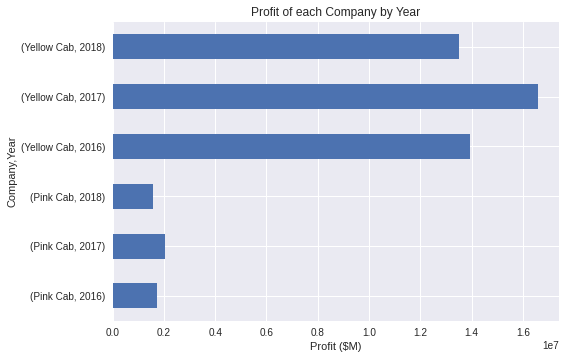

In [98]:
plt.title('Profit of each Company by Year')
plt.xlabel('Profit ($M)')
master_df.groupby(['Company', 'Year'])['Profit'].agg('sum').plot(kind = 'barh')
print('2017 was the best year profit-wise for Both companies')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


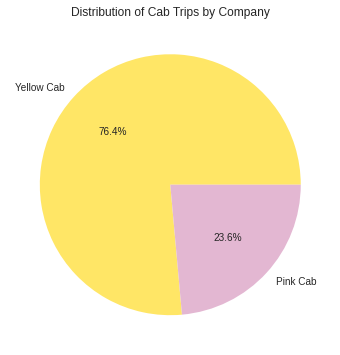

In [99]:
cab_palette = ['#ffe666', '#e3b7d2']

plt.figure(figsize=(6,6))
plt.title('Distribution of Cab Trips by Company')
master_df.Company.value_counts().plot(kind = 'pie', colors=cab_palette, autopct='%1.1f%%')
plt.axes().set_ylabel('')

plt.savefig(GRAPH_PATH + 'Company Volume Distribution.png', dpi=300, format='png')

In [100]:
total_yellow, total_pink = master_df.Company.value_counts()[0], master_df.Company.value_counts()[1]
profits = master_df.groupby('Company').agg({'Profit': 'sum'})
costs = master_df.groupby('Company').agg({'Cost of Trip': 'sum'})

profit_ratios = [profits.iloc[0]/total_pink, profits.iloc[1]/total_yellow]
cost_ratios = [costs.iloc[0]/total_pink, costs.iloc[1]/total_yellow]

cabss = pd.concat([profits, costs, pd.DataFrame(profit_ratios).iloc[:,0],  pd.DataFrame(cost_ratios).iloc[:,0]], axis=1)
cabss.columns = ['Total Profit', 'Total Cost of Rides', 'Avg Profit/Ride', 'Avg Cost/Ride']
cabss['Profit/Cost Ratio'] = cabss['Avg Profit/Ride']/cabss['Avg Cost/Ride']
cabss

,Total Profit,Total Cost of Rides,Avg Profit/Ride,Avg Cost/Ride,Profit/Cost Ratio
Company,,,,,
Pink Cab,5.307328e+06,2.102092e+07,62.652174,248.148682,0.252478
Yellow Cab,4.402037e+07,8.183351e+07,160.259986,297.922004,0.537926


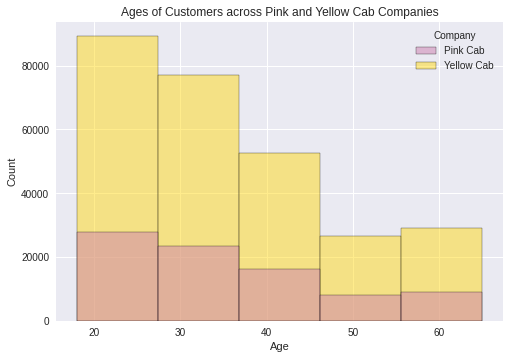

In [101]:
plt.title('Ages of Customers across Pink and Yellow Cab Companies')
sns.histplot(master_df, x = 'Age', hue='Company', palette=['#ce80b0', '#ffda1a'], bins=5)
plt.savefig(GRAPH_PATH + 'Age Demographic.png', dpi=300, format='png')

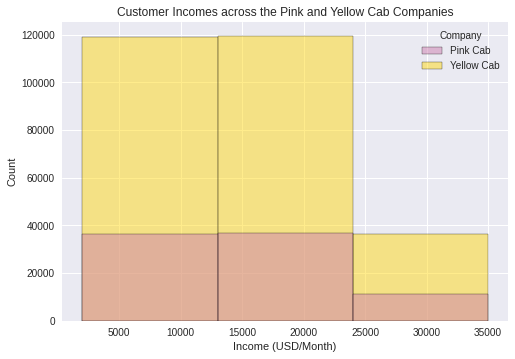

In [102]:
plt.style.use('seaborn-deep')
plt.title('Customer Incomes across the Pink and Yellow Cab Companies')
sns.histplot(master_df, x = 'Income (USD/Month)', hue='Company', palette=['#ce80b0', '#ffda1a'], bins=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


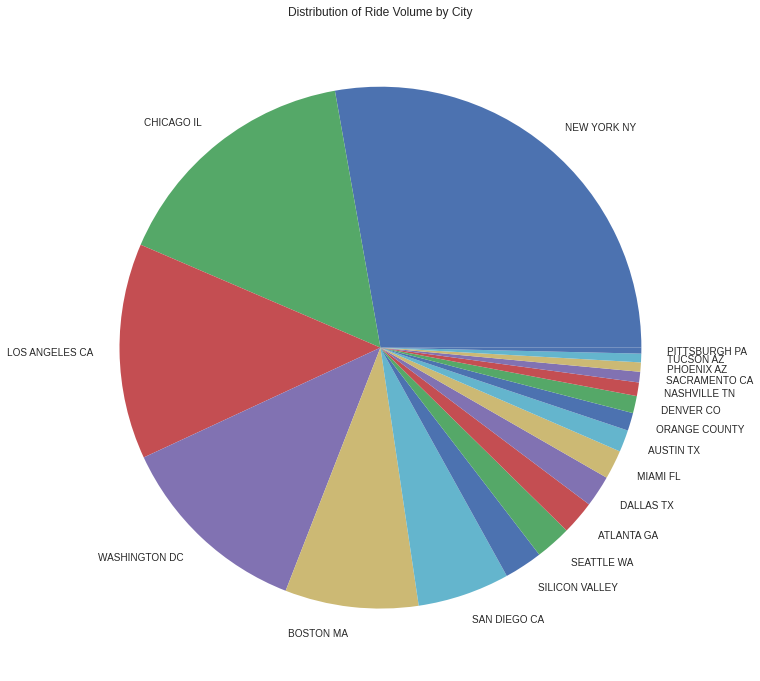

In [103]:
plt.figure(figsize=(12, 12))
plt.title("Distribution of Ride Volume by City")
master_df.City.value_counts().plot(kind = 'pie')
plt.axes().set_ylabel('')
plt.savefig(GRAPH_PATH + 'Ride Volume by City.png', dpi=300, format='png')

## Further EDA

In [104]:
master_p = master_df.loc[master_df.Company == 'Pink Cab']
master_p.drop('Company', axis=1, inplace = True)

master_y = master_df.loc[master_df.Company == 'Yellow Cab']
master_y.drop('Company', axis=1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [105]:
master_df.groupby(['Company', 'City'])['KM Travelled'].sum().nlargest(8)

Company     City          
Yellow Cab  NEW YORK NY       1932842.47
            CHICAGO IL        1070978.26
            WASHINGTON DC      906038.71
            LOS ANGELES CA     639078.88
            BOSTON MA          552454.67
Pink Cab    LOS ANGELES CA     449656.77
            NEW YORK NY        315967.27
            SAN DIEGO CA       240703.87
Name: KM Travelled, dtype: float64

In [106]:
master_df.groupby('City')['Profit'].mean().nlargest(25)

City
NEW YORK NY       279.947491
DALLAS TX         160.856957
SILICON VALLEY    154.561013
MIAMI FL          117.493220
ORANGE COUNTY     114.766920
ATLANTA GA        111.477158
AUSTIN TX         107.577824
DENVER CO         103.943793
PHOENIX AZ         93.479109
LOS ANGELES CA     91.847452
WASHINGTON DC      79.860762
SAN DIEGO CA       77.467955
SEATTLE WA         75.613962
TUCSON AZ          72.636300
PITTSBURGH PA      64.863638
CHICAGO IL         59.820104
BOSTON MA          59.568883
NASHVILLE TN       49.678478
SACRAMENTO CA      49.567466
Name: Profit, dtype: float64

Customer Retention

In [107]:
pink_users = master_p['Customer ID'].value_counts().sum()
pmask5 = master_p['Customer ID'].value_counts() >4
pmask2 = master_p['Customer ID'].value_counts() >1
pmask1 = master_p['Customer ID'].value_counts() ==1
print('%f of Total Customers Used the Company again (> 5x)' % (master_p['Customer ID'].value_counts().loc[pmask5].sum()/pink_users))
print('%f of Total Customers Used the Company again (>= 2x)' % (master_p['Customer ID'].value_counts().loc[pmask2].sum()/pink_users))
print('%f of Total Customers Used the Company only once' % (master_p['Customer ID'].value_counts().loc[pmask1].sum()/pink_users))

0.436012 of Total Customers Used the Company again (> 5x)
0.830789 of Total Customers Used the Company again (>= 2x)
0.169211 of Total Customers Used the Company only once


In [108]:
yellow_users = master_y['Customer ID'].value_counts().sum()
ymask5 = master_y['Customer ID'].value_counts() >4
ymask2 = master_y['Customer ID'].value_counts() >1
ymask1 = master_y['Customer ID'].value_counts() ==1
print('%f of Total Customers Used the Company again (> 5x)' % (master_y['Customer ID'].value_counts().loc[ymask5].sum()/yellow_users))
print('%f of Total Customers Used the Company again (>= 2x)' % (master_y['Customer ID'].value_counts().loc[ymask2].sum()/yellow_users))
print('%f of Total Customers Used the Company only once' % (master_y['Customer ID'].value_counts().loc[ymask1].sum()/yellow_users))

0.841664 of Total Customers Used the Company again (> 5x)
0.956200 of Total Customers Used the Company again (>= 2x)
0.043800 of Total Customers Used the Company only once


Central Tendencies of a Rider's Income based on Gender





In [109]:
customer_data.groupby('Gender')[['Age', 'Income (USD/Month)']].mean()
print("Male and Female Customers have an average (mean) age of 35 and generate $15,000/mo. Males are slightly older and generate a little bit more income")

Male and Female Customers have an average (mean) age of 35 and generate $15,000/mo. Males are slightly older and generate a little bit more income


In [110]:
customer_data.groupby('Gender')[['Age', 'Income (USD/Month)']].median()
print("Male and Female customers have a median age of 33 and a slightly less median Income of ~$14,600")

Male and Female customers have a median age of 33 and a slightly less median Income of ~$14,600


In [111]:
transaction_data['Payment_Mode'].value_counts()

Card    263991
Cash    176107
Name: Payment_Mode, dtype: int64

# Scaled Data, Algos, and Pipelines

## Data Split & Pickle

In [112]:
#BASELINE Data split
ump_y = usable_master_pink.Profit
ump_X = usable_master_pink.drop(['Profit', 'Date of Travel', 'Company'], axis = 1)

base_pX_train, base_pX_test, base_py_train, base_py_test = train_test_split(ump_X, ump_y, test_size = .2, random_state = 42)
base_pX_train, base_pX_valid, base_py_train, base_py_valid = train_test_split(base_pX_train, base_py_train, test_size = 0.25, random_state = 42)

umy_y = usable_master_yellow.Profit
umy_X = usable_master_yellow.drop(['Profit', 'Date of Travel', 'Company'], axis = 1)

base_yX_train, base_yX_test, base_yy_train, base_yy_test = train_test_split(umy_X, umy_y, test_size = .2, random_state = 42)
base_yX_train, base_yX_valid, base_yy_train, base_yy_valid = train_test_split(base_yX_train, base_yy_train, test_size = 0.25, random_state = 42)

In [113]:
#SCALED Data split
y_p = master_p['Profit']
X_p = master_p.drop('Profit', axis = 1)

pX_train, pX_test, py_train, py_test = train_test_split(X_p, y_p, test_size = .2, random_state = 42)
pX_train, pX_valid, py_train, py_valid = train_test_split(pX_train, py_train, test_size = 0.25, random_state = 42)

y_yellow = master_y['Profit']
X_yellow = master_y.drop('Profit', axis = 1)

yX_train, yX_test, yy_train, yy_test = train_test_split(X_yellow, y_yellow, test_size = .2, random_state = 42)
yX_train, yX_valid, yy_train, yy_valid = train_test_split(pX_train, py_train, test_size = 0.25, random_state = 42)

In [114]:
PICKLE_PATH = '/content/drive/MyDrive/Data Glacier Internship Spring 2021/Pickled Data/'

'''Pickle Baseline Pink Data'''
with open(PICKLE_PATH + 'Baseline/' + 'p_Xtrain', 'wb') as temp0:
    pickle.dump(pX_train, temp0)
with open(PICKLE_PATH + 'Baseline/' + 'p_ytrain', 'wb') as temp0:
    pickle.dump(py_train, temp0)
with open(PICKLE_PATH + 'Baseline/' + 'p_Xtest', 'wb') as temp0:
    pickle.dump(pX_test, temp0)
with open(PICKLE_PATH + 'Baseline/' + 'p_ytest', 'wb') as temp0:
    pickle.dump(py_test, temp0)

'''Pickle Baseline Yellow Data'''
with open(PICKLE_PATH + 'Baseline/' + 'y_Xtrain', 'wb') as temp0:
    pickle.dump(yX_train, temp0)
with open(PICKLE_PATH + 'Baseline/' + 'y_ytrain', 'wb') as temp0:
    pickle.dump(yy_train, temp0)
with open(PICKLE_PATH + 'Baseline/' + 'y_Xtest', 'wb') as temp0:
    pickle.dump(yX_test, temp0)
with open(PICKLE_PATH + 'Baseline/' + 'y_ytest', 'wb') as temp0:
    pickle.dump(yy_test, temp0)

In [115]:
'''Pickle Scaled Pink Data'''
with open(PICKLE_PATH + 'Scaled/' + 'p_Xtrain', 'wb') as temp0:
    pickle.dump(pX_train, temp0)
with open(PICKLE_PATH + 'Scaled/' + 'p_ytrain', 'wb') as temp0:
    pickle.dump(py_train, temp0)
with open(PICKLE_PATH + 'Scaled/' + 'p_Xtest', 'wb') as temp0:
    pickle.dump(pX_test, temp0)
with open(PICKLE_PATH + 'Scaled/' + 'p_ytest', 'wb') as temp0:
    pickle.dump(py_test, temp0)

'''Pickle Scaled Yellow Data'''
with open(PICKLE_PATH + 'Scaled/' + 'y_Xtrain', 'wb') as temp0:
    pickle.dump(yX_train, temp0)
with open(PICKLE_PATH + 'Scaled/' + 'y_ytrain', 'wb') as temp0:
    pickle.dump(yy_train, temp0)
with open(PICKLE_PATH + 'Scaled/' + 'y_Xtest', 'wb') as temp0:
    pickle.dump(yX_test, temp0)
with open(PICKLE_PATH + 'Scaled/' + 'y_ytest', 'wb') as temp0:
    pickle.dump(yy_test, temp0)

## Generate Pipelines for Modeling

#### Transformers (Baseline + Scaled)

In [116]:
base_cat_features = ['Payment_Mode', 'City', 'Gender']

In [117]:
numeric_features = ['Transaction ID', 'KM Travelled', 'Price Charged', 'Cost of Trip', 'Customer ID', 'Age', 'Income (USD/Month)', '% of Population that are Users', 'Population'] #omit Profit
cat_features = ['Users', 'Month', 'Year', 'Payment_Mode', 'Customer_Gender_Male', 'City', 'Timezone', 'on_holiday']

cat_transform = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

cat_transform_p = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transform_p = Pipeline(steps = [('numscale', StandardScaler())])

cat_transform_y = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transform_y = Pipeline(steps = [('numscale', StandardScaler())])

#Preprocessors
baseline_preprocessor = ColumnTransformer(
    transformers = [
        ('cat_base', cat_transform, base_cat_features)
    ], remainder = 'passthrough')

preprocess_p = ColumnTransformer(
    transformers = [
        ('num_p', num_transform_p, numeric_features),
        ('cat_p', cat_transform_p, cat_features)
    ], remainder = 'passthrough')

preprocess_y = ColumnTransformer(
    transformers = [
        ('num_y', num_transform_y, numeric_features),
        ('cat_y', cat_transform_y, cat_features)
    ], remainder = 'passthrough')

#### Pipelines (Baseline + Scaled)

In [118]:
#PINK - Baseline Pipelines
rf_basep = Pipeline(steps = [('preprocess', baseline_preprocessor),
                            ('RF_baseline', RandomForestRegressor())])

lr_basep = Pipeline(steps = [('preprocess', baseline_preprocessor),
                            ('LR_baseline', LinearRegression())])

gbr_basep = Pipeline(steps = [('preprocess', baseline_preprocessor),
                            ('GBR_baseline', GradientBoostingRegressor())])

lgbr_basep = Pipeline(steps = [('preprocess', baseline_preprocessor),
                            ('LGBR_baseline', LGBMRegressor())])

xgbr_basep =Pipeline(steps = [('preprocess', baseline_preprocessor),
                            ('XGBR_baseline', XGBRegressor())])

#Yellow - Baseline Pipelines
rf_basey = Pipeline(steps = [('preprocess', baseline_preprocessor),
                            ('RF_baseline', RandomForestRegressor())])

lr_basey = Pipeline(steps = [('preprocess', baseline_preprocessor),
                            ('LR_baseline', LinearRegression())])

gbr_basey = Pipeline(steps = [('preprocess', baseline_preprocessor),
                            ('GBR_baseline', GradientBoostingRegressor())])

lgbr_basey = Pipeline(steps = [('preprocess', baseline_preprocessor),
                            ('LGBR_baseline', LGBMRegressor())])

xgbr_basey =Pipeline(steps = [('preprocess', baseline_preprocessor),
                            ('XGBR_baseline', XGBRegressor())])

In [119]:
#PINK - Final Pipelines
rf_p = Pipeline(steps = [('preprocess', preprocess_p),
                            ('RF_p', RandomForestRegressor())])

lr_p = Pipeline(steps = [('preprocess', preprocess_p),
                            ('LR_p', LinearRegression())])

gbr_p = Pipeline(steps = [('preprocess', preprocess_p),
                            ('GBR_p', GradientBoostingRegressor())])

lgbr_p = Pipeline(steps = [('preprocess', preprocess_p),
                            ('LGBR_p', LGBMRegressor())])

xgbr_p =Pipeline(steps = [('preprocess', preprocess_p),
                            ('XGBR_p', XGBRegressor())])

#Yellow - Final Pipelines
rf_y = Pipeline(steps = [('preprocess', preprocess_y),
                            ('RF_y', RandomForestRegressor())])

lr_y = Pipeline(steps = [('preprocess', preprocess_y),
                            ('LR_y', LinearRegression())])

gbr_y = Pipeline(steps = [('preprocess', preprocess_y),
                            ('GBR_y', GradientBoostingRegressor())])

lgbr_y = Pipeline(steps = [('preprocess', preprocess_y),
                            ('LGBR_y', LGBMRegressor())])

xgbr_y =Pipeline(steps = [('preprocess', preprocess_y),
                            ('XGBR_y', XGBRegressor())])

## Pink Scores (Cross-Val, RMSE)

### Base Scores

In [120]:
base_rf_pink = cross_val_score(rf_basep, base_pX_train, base_py_train)
base_lr_pink = cross_val_score(lr_basep, base_pX_train, base_py_train)
base_gbr_pink = cross_val_score(gbr_basep, base_pX_train, base_py_train)
base_lgbr_pink = cross_val_score(lgbr_basep, base_pX_train, base_py_train)
base_xgbr_pink = cross_val_score(xgbr_basep, base_pX_train, base_py_train)

[23:25:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:25:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:25:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:25:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:25:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [121]:
base_pink_scores = pd.Series({'Random Forest Regressor': np.sqrt(base_rf_pink.mean()), 'Linear Regressor': np.sqrt(base_lr_pink.mean()), 'Gradient Boosting Regressor': np.sqrt(base_gbr_pink.mean()), 
                                 'Light Gradient Boosting Regressor': np.sqrt(base_lgbr_pink.mean()), 'XGBRegressor': np.sqrt(base_xgbr_pink.mean())})
base_pink_scores

Random Forest Regressor              0.999529
Linear Regressor                     1.000000
Gradient Boosting Regressor          0.993359
Light Gradient Boosting Regressor    0.995738
XGBRegressor                         0.993065
dtype: float64

### Scaled Pink Scores

In [122]:
scaled_lr_pink = cross_val_score(lr_p, pX_train, py_train)

In [123]:
scaled_gbr_pink = cross_val_score(gbr_p, pX_train, py_train)

In [124]:
scaled_lgbr_pink = cross_val_score(lgbr_p, pX_train, py_train)

In [125]:
scaled_xgbr_pink = cross_val_score(xgbr_p, pX_train, py_train)

[23:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
scaled_rf_pink = cross_val_score(rf_p, pX_train, py_train, cv=3)

In [ ]:
scaled_pink_scores = pd.Series({'Random Forest Regressor': np.sqrt(scaled_rf_pink.mean()), 'Linear Regressor': np.sqrt(scaled_lr_pink.mean()), 'Gradient Boosting Regressor': np.sqrt(scaled_gbr_pink.mean()), 
                                 'Light Gradient Boosting Regressor': np.sqrt(scaled_lgbr_pink.mean()), 'XGBRegressor': np.sqrt(scaled_xgbr_pink.mean())})
scaled_pink_scores

### FINAL- Visualize

In [ ]:
pink_scores = pd.concat([base_pink_scores, scaled_pink_scores], axis=1)
pink_scores.columns = ['Base', 'Scaled']
pink_scores

In [ ]:
pink_scores.sort_values(ascending = False, by='Scaled').plot(kind = 'barh')
plt.title("Cross Validation RMSE of the Pink Cab's Profit")
plt.legend(bbox_to_anchor = (1.01, 0.6))
plt.xlim(0.9, 1)

In [ ]:
print('XGBRegressor has the lowest error for both base and scaled models - scaled transformations only reduces errors by a very small amount')

## Yellow Scores (Cross-Val, RMSE)

### Base Yellow Scores

In [ ]:
base_rf_yellow = cross_val_score(rf_basey, base_yX_train, base_yy_train)
base_lr_yellow = cross_val_score(lr_basey, base_yX_train, base_yy_train)
base_gbr_yellow = cross_val_score(gbr_basey, base_yX_train, base_yy_train)
base_lgbr_yellow = cross_val_score(lgbr_basey, base_yX_train, base_yy_train)
base_xgbr_yellow = cross_val_score(xgbr_basey, base_yX_train, base_yy_train)

In [ ]:
base_yellow_scores = pd.Series({'Random Forest Regressor': np.sqrt(base_rf_yellow.mean()), 'Linear Regressor': np.sqrt(base_lr_yellow.mean()), 'Gradient Boosting Regressor': np.sqrt(base_gbr_yellow.mean()), 
                                 'Light Gradient Boosting Regressor': np.sqrt(base_lgbr_yellow.mean()), 'XGBRegressor': np.sqrt(base_xgbr_yellow.mean())})
base_yellow_scores

### Scaled Yellow Scores

In [ ]:
scaled_rf_yellow = cross_val_score(rf_y, yX_train, yy_train)
scaled_lr_yellow = cross_val_score(lr_y, yX_train, yy_train)
scaled_gbr_yellow = cross_val_score(gbr_y, yX_train, yy_train)
scaled_lgbr_yellow = cross_val_score(lgbr_y, yX_train, yy_train)
scaled_xgbr_yellow = cross_val_score(xgbr_y, yX_train, yy_train)

In [ ]:
scaled_yellow_scores = pd.Series({'Random Forest Regressor': np.sqrt(scaled_rf_yellow.mean()), 'Linear Regressor': np.sqrt(scaled_lr_yellow.mean()), 'Gradient Boosting Regressor': np.sqrt(scaled_gbr_yellow.mean()), 
                                 'Light Gradient Boosting Regressor': np.sqrt(scaled_lgbr_yellow.mean()), 'XGBRegressor': np.sqrt(scaled_xgbr_yellow.mean())})
scaled_yellow_scores

### FINAL- Visualize

In [ ]:
yellow_scores = pd.concat([base_yellow_scores, scaled_yellow_scores], axis=1)
yellow_scores.columns = ['Base', 'Scaled']
yellow_scores

In [ ]:
yellow_scores.sort_values(ascending = False, by='Scaled').plot(kind = 'barh')
plt.title("Cross Validation RMSE of the Yellow Cab's Profit")
plt.legend(bbox_to_anchor = (1.01, 0.6))
plt.xlim(0.9, 1)

In [ ]:
print('XGBRegressor has the lowest error for both base and scaled models - scaled transformations only reduces errors by a very small amount')

# Fit and Score models on Validation data

## Fit and score Top 3 Models: XGBR, GBR, LGBR

### Pink

In [ ]:
valid_score_p = {}
model_names = ['XGBRegressor', 'Gradient Boosting Regressor', 'Light Gradient Boosting Regressor', 'Random Forest Regressor', 'Linear Regressor']
pink_pipelines = [xgbr_p, gbr_p, lgbr_p, rf_p, lr_p]

for model, name in zip(pink_pipelines, model_names):
    print('Scoring the {} pipeline...'.format(name))
    score = fitscore(model, pX_train, py_train, pX_valid, py_valid, 3)
    valid_score_p[name] = score
print('\n')
print('Finished!')
valid_score_p

In [ ]:
feature_weights(lr_p)

In [ ]:
lr_p[1].intercept_

### Yellow

In [ ]:
valid_score_y = {}
model_names = ['XGBRegressor', 'Gradient Boosting Regressor', 'Light Gradient Boosting Regressor', 'Random Forest Regressor', 'Linear Regressor']
yellow_pipelines = [xgbr_y, gbr_y, lgbr_y, rf_y, lr_y]

for model, name in zip(yellow_pipelines, model_names):
    print('Scoring the {} pipeline...'.format(name))
    score = fitscore(model, yX_train, yy_train, yX_valid, yy_valid, 3)
    valid_score_y[name] = score
print('\n')
print('Finished!')
valid_score_y

In [ ]:
feature_weights(lr_y)

In [ ]:
lr_y[1].intercept_

# Final Scores - Test Data

### Pink

In [ ]:
test_score_p = {}
model_names = ['XGBRegressor', 'Gradient Boosting Regressor', 'Light Gradient Boosting Regressor', 'Random Forest Regressor', 'Linear Regressor']
pink_pipelines = [xgbr_p, gbr_p, lgbr_p, rf_p, lr_p]

for model, name in zip(pink_pipelines, model_names):
    print('Scoring the {} pipeline...'.format(name))
    score = fitscore(model, pX_train, py_train, pX_test, py_test, 3)
    test_score_p[name] = score
print('\n')
print('Finished!')
test_score_p

In [ ]:
pX_test.shape

In [ ]:
py_test.shape

In [ ]:
lr_p.fit(pX_train, py_train)
pred_p = lr_p.predict(pX_test)

In [ ]:
feature_weights(lr_p)

In [ ]:
lr_p[1].intercept_

### Yellow

In [ ]:
test_score_y = {}
model_names = ['XGBRegressor', 'Gradient Boosting Regressor', 'Light Gradient Boosting Regressor', 'Random Forest Regressor', 'Linear Regressor']
yellow_pipelines = [xgbr_y, gbr_y, lgbr_y, rf_y, lr_y]

for model, name in zip(yellow_pipelines, model_names):
    print('Scoring the {} pipeline...'.format(name))
    score = fitscore(model, yX_train, yy_train, yX_test, yy_test, 3)
    test_score_y[name] = score
print('\n')
print('Finished!')
test_score_y

In [ ]:
feature_weights(lr_y)

In [ ]:
lr_y[1].intercept_

In [ ]:
master_df.info()

In [ ]:
lr_y.fit(yX_train, yy_train)
pred_y = lr_y.predict(yX_test)

In [ ]:
plt.scatter(yX_test, yy_test, color = 'black')
plt.plot(yX_test, pred_y, color = 'blue')
plt.show()

In [ ]:
master_df.shape